 > # **Foodie Project**

**Business case:** There will be a foodie fair in your city next summer, and the organsers have contacted us because they are interested in performing an analysis of the world wide cuisines. They manage to obtain a dataset from different cuisines all over the world, together with the list of the most common ingredients.

Some of our strongest geographic and cultural associations are tied to a region's local foods, so they are interested to know more information regarding them in order to organise the different stands.

In [1]:
import json
import numpy as np 
import pandas as pd 

# text processing libraries
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# sklearn 
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# Other imports
from collections import Counter
import requests
import imageio
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from matplotlib import pyplot as plt
from PIL import Image


## Import data

In [2]:
import sys
sys.path.append('D:\Data Course\Projects\Food\Food-Project')

from My_functions_EDA import *
from fx_MLRegression import *

In [3]:
# Add the name of the file
data=json.load(open(r'../dataset/Ex 6.1. foodie_dataset.json'))

In [4]:
df = pd.DataFrame(data)

In [5]:
df

id      cuisine                                        ingredients
0      10259        greek  [romaine lettuce, black olives, grape tomatoes...
1      25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...
2      20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...
3      22213       indian                [water, vegetable oil, wheat, salt]
4      13162       indian  [black pepper, shallots, cornflour, cayenne pe...
...      ...          ...                                                ...
39769  29109        irish  [light brown sugar, granulated sugar, butter, ...
39770  11462      italian  [KRAFT Zesty Italian Dressing, purple onion, b...
39771   2238        irish  [eggs, citrus fruit, raisins, sourdough starte...
39772  41882      chinese  [boneless chicken skinless thigh, minced garli...
39773   2362      mexican  [green chile, jalapeno chilies, onions, ground...

[39774 rows x 3 columns]

In [6]:
#Missing values in training set
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


# Exploring cuisine column

In [7]:
df.cuisine.value_counts()

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

In [8]:
fig = px.bar(x = df['cuisine'].value_counts().index, y = df['cuisine'].value_counts(), template="plotly_white",
            labels={'x':'Cuisine', 'y': 'Amount of Recipies'})
fig.show()

# Cleaning Ingredients Column

In [9]:
#Create a new column -called Clean - where the ingredients are a string not a list
df['clean'] = df.ingredients.apply(', '.join)

# Modify the Clean Column replacing the ',' by the key word 'hola' -Hello in Spanish- 
# the reason is have a work-key total different to the ingredients 
# and using a word I can clean the special characters as dots and comas
df['clean'] = df['clean'].str.replace(',',' hola')

In [10]:
type(df.ingredients[0])

list

In [11]:
type(df.clean[0])

str

In [12]:
#Generate a Counter to check what are the word most frecuent, using the key-word 'hola' as splitter
from collections import Counter
vocab = Counter()
for recipe in df['clean']:
    for word in recipe.split('hola'):
        vocab[word.strip()] += 1

In [13]:
#The problem now is the 'salt' and 'salts' are count as different word being the same ingredient
vocab.most_common(15)

[('salt', 18049),
 ('onions', 7972),
 ('olive oil', 7972),
 ('water', 7457),
 ('garlic', 7380),
 ('sugar', 6434),
 ('garlic cloves', 6237),
 ('butter', 4848),
 ('ground black pepper', 4785),
 ('all-purpose flour', 4632),
 ('pepper', 4438),
 ('vegetable oil', 4385),
 ('eggs', 3388),
 ('soy sauce', 3296),
 ('kosher salt', 3113)]

count_vectorizer = CountVectorizer(max_features = 1500)
train_vectors = count_vectorizer.fit_transform(df['clean'])
#pred_vectors = count_vectorizer.transform(pred["text2"])
train_vectors
#pred_vectors

In [14]:
#Tokenized the problem to fix that problem
def tokenize(text):
    tokens=re.split('\W+',text)
    return tokens 

df['tokenized_text']=df['clean'].apply(lambda row : tokenize(row.lower()))

In [15]:
#Remove the stop words to more uniformity in the text
def remove_stopwords(text):
    stopwords=nltk.corpus.stopwords.words('english')

    clean_text=[word for word in text if word not in stopwords]
    return clean_text 

df['w_stop']=df['tokenized_text'].apply(lambda row : remove_stopwords(row))

In [16]:
df

id      cuisine                                        ingredients  \
0      10259        greek  [romaine lettuce, black olives, grape tomatoes...   
1      25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...   
2      20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...   
3      22213       indian                [water, vegetable oil, wheat, salt]   
4      13162       indian  [black pepper, shallots, cornflour, cayenne pe...   
...      ...          ...                                                ...   
39769  29109        irish  [light brown sugar, granulated sugar, butter, ...   
39770  11462      italian  [KRAFT Zesty Italian Dressing, purple onion, b...   
39771   2238        irish  [eggs, citrus fruit, raisins, sourdough starte...   
39772  41882      chinese  [boneless chicken skinless thigh, minced garli...   
39773   2362      mexican  [green chile, jalapeno chilies, onions, ground...   

                                                   clean  \
0      romaine lettuce hola black olives hola grape t...   
1      plain flour hola ground pepper hola salt hola ...   
2      eggs hola pepper hola salt hola mayonaise hola...   
3          water hola vegetable oil hola wheat hola salt   
4      black pepper hola shallots hola cornflour hola...   
...                                                  ...   
39769  light brown sugar hola granulated sugar hola b...   
39770  KRAFT Zesty Italian Dressing hola purple onion...   
39771  eggs hola citrus fruit hola raisins hola sourd...   
39772  boneless chicken skinless thigh hola minced ga...   
39773  green chile hola jalapeno chilies hola onions ...   

                                          tokenized_text  \
0      [romaine, lettuce, hola, black, olives, hola, ...   
1      [plain, flour, hola, ground, pepper, hola, sal...   
2      [eggs, hola, pepper, hola, salt, hola, mayonai...   
3      [water, hola, vegetable, oil, hola, wheat, hol...   
4      [black, pepper, hola, shallots, hola, cornflou...   
...                                                  ...   
39769  [light, brown, sugar, hola, granulated, sugar,...   
39770  [kraft, zesty, italian, dressing, hola, purple...   
39771  [eggs, hola, citrus, fruit, hola, raisins, hol...   
39772  [boneless, chicken, skinless, thigh, hola, min...   
39773  [green, chile, hola, jalapeno, chilies, hola, ...   

                                                  w_stop  
0      [romaine, lettuce, hola, black, olives, hola, ...  
1      [plain, flour, hola, ground, pepper, hola, sal...  
2      [eggs, hola, pepper, hola, salt, hola, mayonai...  
3      [water, hola, vegetable, oil, hola, wheat, hol...  
4      [black, pepper, hola, shallots, hola, cornflou...  
...                                                  ...  
39769  [light, brown, sugar, hola, granulated, sugar,...  
39770  [kraft, zesty, italian, dressing, hola, purple...  
39771  [eggs, hola, citrus, fruit, hola, raisins, hol...  
39772  [boneless, chicken, skinless, thigh, hola, min...  
39773  [green, chile, hola, jalapeno, chilies, hola, ...  

[39774 rows x 6 columns]

In [17]:
#Now Lemmatize the ingredients
lemmatizer = WordNetLemmatizer()
def lemmatizer2(tokenized_text):
    lematize_text=[lemmatizer.lemmatize(word) for word in tokenized_text]
    return lematize_text

df['lemmatizer_text']=df['w_stop'].apply(lambda row : lemmatizer2(row))
df.head()

id      cuisine                                        ingredients  \
0  10259        greek  [romaine lettuce, black olives, grape tomatoes...   
1  25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...   
2  20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...   
3  22213       indian                [water, vegetable oil, wheat, salt]   
4  13162       indian  [black pepper, shallots, cornflour, cayenne pe...   

                                               clean  \
0  romaine lettuce hola black olives hola grape t...   
1  plain flour hola ground pepper hola salt hola ...   
2  eggs hola pepper hola salt hola mayonaise hola...   
3      water hola vegetable oil hola wheat hola salt   
4  black pepper hola shallots hola cornflour hola...   

                                      tokenized_text  \
0  [romaine, lettuce, hola, black, olives, hola, ...   
1  [plain, flour, hola, ground, pepper, hola, sal...   
2  [eggs, hola, pepper, hola, salt, hola, mayonai...   
3  [water, hola, vegetable, oil, hola, wheat, hol...   
4  [black, pepper, hola, shallots, hola, cornflou...   

                                              w_stop  \
0  [romaine, lettuce, hola, black, olives, hola, ...   
1  [plain, flour, hola, ground, pepper, hola, sal...   
2  [eggs, hola, pepper, hola, salt, hola, mayonai...   
3  [water, hola, vegetable, oil, hola, wheat, hol...   
4  [black, pepper, hola, shallots, hola, cornflou...   

                                     lemmatizer_text  
0  [romaine, lettuce, hola, black, olive, hola, g...  
1  [plain, flour, hola, ground, pepper, hola, sal...  
2  [egg, hola, pepper, hola, salt, hola, mayonais...  
3  [water, hola, vegetable, oil, hola, wheat, hol...  
4  [black, pepper, hola, shallot, hola, cornflour...

In [18]:
#And after that transformation we trasform the list of without stopwords -w_stop- into string 
df['final'] = df.lemmatizer_text.apply(' '.join)

In [19]:
type(df.lemmatizer_text[35563])

list

In [20]:
type(df.final[35563])

str

In [21]:
#And now we can select a word to filter
df[df.final.str.contains('chicken')]

id     cuisine                                        ingredients  \
2      20130    filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...   
4      13162      indian  [black pepper, shallots, cornflour, cayenne pe...   
14     31908     italian  [fresh parmesan cheese, butter, all-purpose fl...   
17      1420     italian  [italian seasoning, broiler-fryer chicken, may...   
19      8152  vietnamese  [soy sauce, vegetable oil, red bell pepper, ch...   
...      ...         ...                                                ...   
39754  27082  vietnamese  [jasmine rice, bay leaves, sticky rice, rotiss...   
39761   6487     chinese  [honey, chicken breast halves, cilantro leaves...   
39762  26646      indian  [curry powder, salt, chicken, water, vegetable...   
39768   7377     mexican  [shredded cheddar cheese, crushed cheese crack...   
39772  41882     chinese  [boneless chicken skinless thigh, minced garli...   

                                                   clean  \
2      eggs hola pepper hola salt hola mayonaise hola...   
4      black pepper hola shallots hola cornflour hola...   
14     fresh parmesan cheese hola butter hola all-pur...   
17     italian seasoning hola broiler-fryer chicken h...   
19     soy sauce hola vegetable oil hola red bell pep...   
...                                                  ...   
39754  jasmine rice hola bay leaves hola sticky rice ...   
39761  honey hola chicken breast halves hola cilantro...   
39762  curry powder hola salt hola chicken hola water...   
39768  shredded cheddar cheese hola crushed cheese cr...   
39772  boneless chicken skinless thigh hola minced ga...   

                                          tokenized_text  \
2      [eggs, hola, pepper, hola, salt, hola, mayonai...   
4      [black, pepper, hola, shallots, hola, cornflou...   
14     [fresh, parmesan, cheese, hola, butter, hola, ...   
17     [italian, seasoning, hola, broiler, fryer, chi...   
19     [soy, sauce, hola, vegetable, oil, hola, red, ...   
...                                                  ...   
39754  [jasmine, rice, hola, bay, leaves, hola, stick...   
39761  [honey, hola, chicken, breast, halves, hola, c...   
39762  [curry, powder, hola, salt, hola, chicken, hol...   
39768  [shredded, cheddar, cheese, hola, crushed, che...   
39772  [boneless, chicken, skinless, thigh, hola, min...   

                                                  w_stop  \
2      [eggs, hola, pepper, hola, salt, hola, mayonai...   
4      [black, pepper, hola, shallots, hola, cornflou...   
14     [fresh, parmesan, cheese, hola, butter, hola, ...   
17     [italian, seasoning, hola, broiler, fryer, chi...   
19     [soy, sauce, hola, vegetable, oil, hola, red, ...   
...                                                  ...   
39754  [jasmine, rice, hola, bay, leaves, hola, stick...   
39761  [honey, hola, chicken, breast, halves, hola, c...   
39762  [curry, powder, hola, salt, hola, chicken, hol...   
39768  [shredded, cheddar, cheese, hola, crushed, che...   
39772  [boneless, chicken, skinless, thigh, hola, min...   

                                         lemmatizer_text  \
2      [egg, hola, pepper, hola, salt, hola, mayonais...   
4      [black, pepper, hola, shallot, hola, cornflour...   
14     [fresh, parmesan, cheese, hola, butter, hola, ...   
17     [italian, seasoning, hola, broiler, fryer, chi...   
19     [soy, sauce, hola, vegetable, oil, hola, red, ...   
...                                                  ...   
39754  [jasmine, rice, hola, bay, leaf, hola, sticky,...   
39761  [honey, hola, chicken, breast, half, hola, cil...   
39762  [curry, powder, hola, salt, hola, chicken, hol...   
39768  [shredded, cheddar, cheese, hola, crushed, che...   
39772  [boneless, chicken, skinless, thigh, hola, min...   

                                                   final  
2      egg hola pepper hola salt hola mayonaise hola ...  
4      black pepper hola shallot hola cornflour hola ...  


In [22]:
# Replace the 'hola' by a , and end the cleaning
df['final']= df['final'].str.replace(' hola' ,',')
df.head()

id      cuisine                                        ingredients  \
0  10259        greek  [romaine lettuce, black olives, grape tomatoes...   
1  25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...   
2  20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...   
3  22213       indian                [water, vegetable oil, wheat, salt]   
4  13162       indian  [black pepper, shallots, cornflour, cayenne pe...   

                                               clean  \
0  romaine lettuce hola black olives hola grape t...   
1  plain flour hola ground pepper hola salt hola ...   
2  eggs hola pepper hola salt hola mayonaise hola...   
3      water hola vegetable oil hola wheat hola salt   
4  black pepper hola shallots hola cornflour hola...   

                                      tokenized_text  \
0  [romaine, lettuce, hola, black, olives, hola, ...   
1  [plain, flour, hola, ground, pepper, hola, sal...   
2  [eggs, hola, pepper, hola, salt, hola, mayonai...   
3  [water, hola, vegetable, oil, hola, wheat, hol...   
4  [black, pepper, hola, shallots, hola, cornflou...   

                                              w_stop  \
0  [romaine, lettuce, hola, black, olives, hola, ...   
1  [plain, flour, hola, ground, pepper, hola, sal...   
2  [eggs, hola, pepper, hola, salt, hola, mayonai...   
3  [water, hola, vegetable, oil, hola, wheat, hol...   
4  [black, pepper, hola, shallots, hola, cornflou...   

                                     lemmatizer_text  \
0  [romaine, lettuce, hola, black, olive, hola, g...   
1  [plain, flour, hola, ground, pepper, hola, sal...   
2  [egg, hola, pepper, hola, salt, hola, mayonais...   
3  [water, hola, vegetable, oil, hola, wheat, hol...   
4  [black, pepper, hola, shallot, hola, cornflour...   

                                               final  
0  romaine lettuce, black olive, grape tomato, ga...  
1  plain flour, ground pepper, salt, tomato, grou...  
2  egg, pepper, salt, mayonaise, cooking oil, gre...  
3                  water, vegetable oil, wheat, salt  
4  black pepper, shallot, cornflour, cayenne pepp...

## Generate the New Data

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               39774 non-null  int64 
 1   cuisine          39774 non-null  object
 2   ingredients      39774 non-null  object
 3   clean            39774 non-null  object
 4   tokenized_text   39774 non-null  object
 5   w_stop           39774 non-null  object
 6   lemmatizer_text  39774 non-null  object
 7   final            39774 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.4+ MB


In [24]:
data= df.copy()

In [25]:
data.drop(axis = 1, columns=["clean", "id", "tokenized_text","w_stop","lemmatizer_text"], inplace= True)

In [26]:
data.loc[143,:]

cuisine                                     mexican
ingredients    [granulated sugar, large egg whites]
final             granulated sugar, large egg white
Name: 143, dtype: object

In [27]:
data.to_csv('../dataset/00-Data_Clean.csv')

# Analyzing the new Data 

In [28]:
df_1 = pd.read_csv('../dataset/00-Data_Clean.csv')
df_1

Unnamed: 0      cuisine  \
0               0        greek   
1               1  southern_us   
2               2     filipino   
3               3       indian   
4               4       indian   
...           ...          ...   
39769       39769        irish   
39770       39770      italian   
39771       39771        irish   
39772       39772      chinese   
39773       39773      mexican   

                                             ingredients  \
0      ['romaine lettuce', 'black olives', 'grape tom...   
1      ['plain flour', 'ground pepper', 'salt', 'toma...   
2      ['eggs', 'pepper', 'salt', 'mayonaise', 'cooki...   
3            ['water', 'vegetable oil', 'wheat', 'salt']   
4      ['black pepper', 'shallots', 'cornflour', 'cay...   
...                                                  ...   
39769  ['light brown sugar', 'granulated sugar', 'but...   
39770  ['KRAFT Zesty Italian Dressing', 'purple onion...   
39771  ['eggs', 'citrus fruit', 'raisins', 'sourdough...   
39772  ['boneless chicken skinless thigh', 'minced ga...   
39773  ['green chile', 'jalapeno chilies', 'onions', ...   

                                                   final  
0      romaine lettuce, black olive, grape tomato, ga...  
1      plain flour, ground pepper, salt, tomato, grou...  
2      egg, pepper, salt, mayonaise, cooking oil, gre...  
3                      water, vegetable oil, wheat, salt  
4      black pepper, shallot, cornflour, cayenne pepp...  
...                                                  ...  
39769  light brown sugar, granulated sugar, butter, w...  
39770  kraft zesty italian dressing, purple onion, br...  
39771  egg, citrus fruit, raisin, sourdough starter, ...  
39772  boneless chicken skinless thigh, minced garlic...  
39773  green chile, jalapeno chilies, onion, ground b...  

[39774 rows x 4 columns]

In [29]:
# checking shape ...
print("The dataset has {} rows and {} columns.".format(*df_1.shape))

# ... and duplicates
print("It contains {} duplicates.".format(df_1.duplicated().sum()))

The dataset has 39774 rows and 4 columns.
It contains 0 duplicates.


In [30]:
# Drop the 'unnamed' column
df_1.drop(columns="Unnamed: 0",inplace= True)

In [31]:
df_1

cuisine                                        ingredients  \
0            greek  ['romaine lettuce', 'black olives', 'grape tom...   
1      southern_us  ['plain flour', 'ground pepper', 'salt', 'toma...   
2         filipino  ['eggs', 'pepper', 'salt', 'mayonaise', 'cooki...   
3           indian        ['water', 'vegetable oil', 'wheat', 'salt']   
4           indian  ['black pepper', 'shallots', 'cornflour', 'cay...   
...            ...                                                ...   
39769        irish  ['light brown sugar', 'granulated sugar', 'but...   
39770      italian  ['KRAFT Zesty Italian Dressing', 'purple onion...   
39771        irish  ['eggs', 'citrus fruit', 'raisins', 'sourdough...   
39772      chinese  ['boneless chicken skinless thigh', 'minced ga...   
39773      mexican  ['green chile', 'jalapeno chilies', 'onions', ...   

                                                   final  
0      romaine lettuce, black olive, grape tomato, ga...  
1      plain flour, ground pepper, salt, tomato, grou...  
2      egg, pepper, salt, mayonaise, cooking oil, gre...  
3                      water, vegetable oil, wheat, salt  
4      black pepper, shallot, cornflour, cayenne pepp...  
...                                                  ...  
39769  light brown sugar, granulated sugar, butter, w...  
39770  kraft zesty italian dressing, purple onion, br...  
39771  egg, citrus fruit, raisin, sourdough starter, ...  
39772  boneless chicken skinless thigh, minced garlic...  
39773  green chile, jalapeno chilies, onion, ground b...  

[39774 rows x 3 columns]

In [32]:
print("It contains {} differents types of cuisine.".format(df_1.cuisine.nunique()))
print(df_1.cuisine.unique())

It contains 20 differents types of cuisine.
['greek' 'southern_us' 'filipino' 'indian' 'jamaican' 'spanish' 'italian'
 'mexican' 'chinese' 'british' 'thai' 'vietnamese' 'cajun_creole'
 'brazilian' 'french' 'japanese' 'irish' 'korean' 'moroccan' 'russian']


In [33]:
df_1.cuisine.value_counts()

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

## Seeing the Lenght of the Recipes

In [34]:
# Created the column length of the recipes 
df_1['Len'] = df_1['final'].apply(lambda row: len(row.split(', ')))

In [35]:
# Check the values of leght
df_1.Len.value_counts().sort_values(ascending=False)

9     3758
10    3677
8     3541
11    3514
7     3320
12    3144
13    2690
6     2659
14    2288
5     1874
15    1810
16    1441
17    1156
4     1113
18     901
19     603
3      548
20     514
21     313
22     218
2      193
23     143
24      91
25      74
26      46
28      27
1       22
29      21
27      20
30      15
31      11
33       4
32       4
36       4
40       3
35       3
34       3
38       2
49       2
52       1
65       1
43       1
59       1
Name: Len, dtype: int64

In [36]:
px.histogram(df_1, x='Len', template="plotly_white")

In [37]:
# Seeing the max and min by cuisine
a = df_1.groupby(['cuisine']).agg({'Len': [np.count_nonzero,np.min,np.max,np.mean,]})
a

Len                     
             count_nonzero amin amax       mean
cuisine                                        
brazilian              467    2   59   9.526767
british                804    2   30   9.712687
cajun_creole          1546    2   31  12.634541
chinese               2673    2   38  11.994014
filipino               755    2   38  10.006623
french                2646    1   31   9.828798
greek                 1175    1   27  10.194894
indian                3003    1   49  12.708292
irish                  667    2   27   9.308846
italian               7838    1   65   9.934294
jamaican               526    2   35  12.224335
japanese              1423    1   34   9.737878
korean                 830    2   29  11.284337
mexican               6438    1   52  10.902454
moroccan               821    2   31  12.913520
russian                489    2   25  10.235174
southern_us           4320    1   40   9.652778
spanish                989    1   35  10.442872
thai                  1539    1   40  12.555556
vietnamese             825    1   31  12.682424

### Reduce the Size of Recipies

In [38]:
df_less = df_1[df_1.Len < 16]
df_less.reset_index(drop=True, inplace = True)
print("We have", df_less.shape[0] , "recipes with less than 16 elements, and We had" , df_1.shape[0])

We have 34151 recipes with less than 16 elements, and We had 39774


In [39]:
df_less

cuisine                                        ingredients  \
0            greek  ['romaine lettuce', 'black olives', 'grape tom...   
1      southern_us  ['plain flour', 'ground pepper', 'salt', 'toma...   
2         filipino  ['eggs', 'pepper', 'salt', 'mayonaise', 'cooki...   
3           indian        ['water', 'vegetable oil', 'wheat', 'salt']   
4         jamaican  ['plain flour', 'sugar', 'butter', 'eggs', 'fr...   
...            ...                                                ...   
34146      mexican  ['shredded cheddar cheese', 'crushed cheese cr...   
34147        irish  ['light brown sugar', 'granulated sugar', 'but...   
34148      italian  ['KRAFT Zesty Italian Dressing', 'purple onion...   
34149        irish  ['eggs', 'citrus fruit', 'raisins', 'sourdough...   
34150      mexican  ['green chile', 'jalapeno chilies', 'onions', ...   

                                                   final  Len  
0      romaine lettuce, black olive, grape tomato, ga...    9  
1      plain flour, ground pepper, salt, tomato, grou...   11  
2      egg, pepper, salt, mayonaise, cooking oil, gre...   12  
3                      water, vegetable oil, wheat, salt    4  
4      plain flour, sugar, butter, egg, fresh ginger ...   12  
...                                                  ...  ...  
34146  shredded cheddar cheese, crushed cheese cracke...   10  
34147  light brown sugar, granulated sugar, butter, w...   12  
34148  kraft zesty italian dressing, purple onion, br...    7  
34149  egg, citrus fruit, raisin, sourdough starter, ...   12  
34150  green chile, jalapeno chilies, onion, ground b...   12  

[34151 rows x 4 columns]

<Figure size 576x360 with 0 Axes>

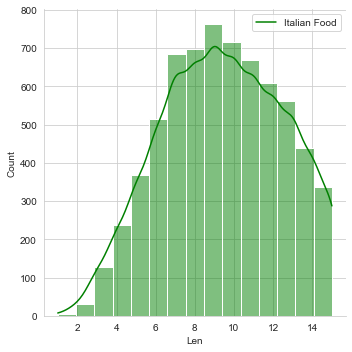

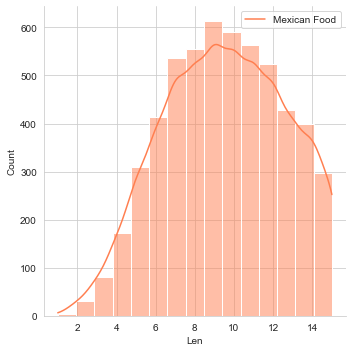

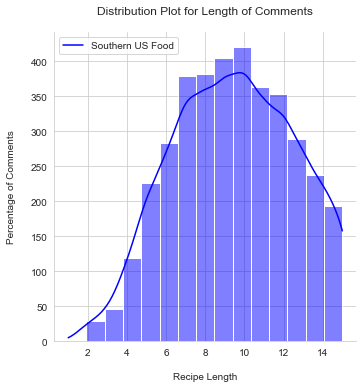

In [40]:
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))

sns.displot(df_less.Len[df_1.cuisine == "italian"], kde=True, bins =15, color='green')
plt.legend([ 'Italian Food'])
sns.displot(df_less.Len[df_1.cuisine == "mexican"], kde=True, bins =15,  color='coral')
plt.legend(['Mexican Food'])
sns.displot(df_less.Len[df_1.cuisine == "southern_us"], kde=True, bins =15, color='blue')
plt.legend([ 'Southern US Food'])

plt.title('Distribution Plot for Length of Comments\n')

plt.xlabel('\nRecipe Length')
plt.ylabel('Percentage of Comments\n');

In [41]:
df_less.groupby(['cuisine']).agg({'Len': [np.min,np.max,np.mean, np.count_nonzero]} )

Len                              
             amin amax       mean count_nonzero
cuisine                                        
brazilian       2   15   8.051980           404
british         2   15   8.868852           732
cajun_creole    2   15  10.561082          1146
chinese         2   15  10.675614          2198
filipino        2   15   9.257225           692
french          1   15   8.917539          2389
greek           1   15   9.431925          1065
indian          1   15  10.343420          2181
irish           2   15   8.780604           629
italian         1   15   9.245233          7238
jamaican        2   15  10.203474           403
japanese        1   15   8.762539          1276
korean          2   15  10.198324           716
mexican         1   15   9.431145          5439
moroccan        2   15  10.451670           569
russian         2   15   9.241935           434
southern_us     1   15   8.937312          3988
spanish         1   15   9.471591           880
thai            1   15  10.770519          1194
vietnamese      1   15   9.980969           578

In [42]:
# see the recipies with less than 3 ingredients
df_less[df_less.Len < 3]

cuisine                               ingredients  \
77         korean                       ['water', 'barley']   
125       mexican  ['granulated sugar', 'large egg whites']   
383       italian             ['aged gouda', 'soppressata']   
815      japanese                            ['sushi rice']   
839       italian             ['melted butter', 'potatoes']   
...           ...                                       ...   
33412  vietnamese                 ['shallots', 'salad oil']   
33472    filipino                  ['adobo', 'cooking oil']   
33530     italian       ['olive oil', 'fresh basil leaves']   
33534     british            ['puff pastry', 'minced meat']   
34088     mexican                    ['warm water', 'masa']   

                                   final  Len  
77                         water, barley    2  
125    granulated sugar, large egg white    2  
383              aged gouda, soppressata    2  
815                           sushi rice    1  
839                melted butter, potato    2  
...                                  ...  ...  
33412                 shallot, salad oil    2  
33472                 adobo, cooking oil    2  
33530        olive oil, fresh basil leaf    2  
33534           puff pastry, minced meat    2  
34088                   warm water, masa    2  

[215 rows x 4 columns]

## Filtering Meat - NoMeat // Sugar - NotSugar

In [43]:
import re
def pattern_searcher(search_str:str, search_list:str):
    search_obj = re.search(search_list, search_str)
    if search_obj :
        return_str = search_str[search_obj.start(): search_obj.end()]
    else:
        return_str = 'No'
    return return_str


In [44]:
# Generate a list with all the types of meats and using that list I generate a pattern to check if the recipies have meat
meat = ['liver ', 'thigh', 'shrimp' , 'steak',  'chorizo', 'sausage', 'pork', 'kosher', 'turkey', 'fillet', 
        'fryer',  'fish', 'loin',  'serrano', 'crab', 'beef',  'burger', 'blood', 'prawn',  'chop', 'cod',  
        'duck',  'lamb', 'oyster', 'tenderloin', 'lard', 'cutlet', 'clam', 'heart', 'rabe', 'shell',  'meat',  
        'salmon', 'ear', 'trout',  "chicken", "pepperoni", "bacon", " ham " ,"veal",  "salami" ,"drumstick" , 
        "breast" ,"goose", "burger",  "lobster", "poultry", "tripe","mutton"]

pattern = '|'.join(meat)

In [45]:
# Generate a list with ingredients make a recipies sweet and using that list I generate a pattern to check it
sweet = ['sugar', "chocolate", 'honey' ]
pattern2 = '|'.join(sweet)

In [46]:
df_less['meat'] = df_1['final'].apply(lambda x: pattern_searcher(search_str=x, search_list=pattern))


In [47]:
df_less.meat.value_counts()

No            12763
chicken        5819
chop           3516
kosher         1772
beef           1598
pork           1210
fish           1117
shrimp          974
bacon           565
sausage         553
steak           393
fillet          350
lamb            300
turkey          291
ear             285
serrano         223
shell           218
oyster          216
salmon          216
meat            186
crab            165
lard            164
loin            160
heart           140
clam            129
chorizo         115
veal             87
cod              83
prawn            75
duck             69
burger           57
salami           53
pepperoni        53
 ham             37
lobster          31
rabe             27
poultry          21
trout            20
mutton           19
fryer            17
blood            11
tripe            11
breast           10
cutlet           10
tenderloin        9
goose             7
liver             5
drumstick         1
Name: meat, dtype: int64

[Text(0.5, 1.0, 'Ten Meets most frequency')]

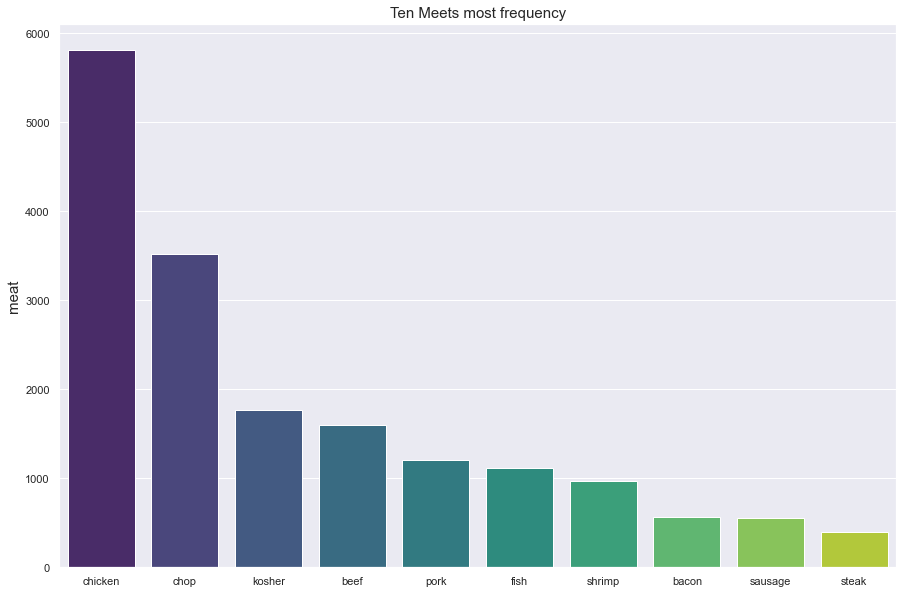

In [48]:
sns.set(rc={'figure.figsize':(15,10),
            'axes.labelsize': 15, 
            'font.size': 20, 
            'legend.fontsize': 12, 
            'axes.titlesize':15,
            'figure.facecolor': 'white',
            'font.family': ['sans-serif'],
            'legend.fancybox': True,
            'lines.color': 'C0',
            'xaxis.labellocation': 'center',
            'xtick.alignment': 'center',
            'legend.title_fontsize': 15,
            'legend.edgecolor': '0.9',
            'animation.ffmpeg_path': 'ffmpeg',
           })    

sns.barplot(df_less['meat'].value_counts().index[1:11],
            df_less['meat'].value_counts()[1:11],palette='viridis').set(title='Ten Meets most frequency')

In [49]:
df_less['sugar'] = df_1['final'].apply(lambda x: pattern_searcher(search_str=x, search_list=pattern2))

In [50]:
nomeat = df_less[(df_less['meat'] == "No") & (df_less['sugar'] == "No")]
nomeat.reset_index(drop=True, inplace = True)
nomeat.head()

cuisine                                        ingredients  \
0        greek  ['romaine lettuce', 'black olives', 'grape tom...   
1  southern_us  ['plain flour', 'ground pepper', 'salt', 'toma...   
2       indian        ['water', 'vegetable oil', 'wheat', 'salt']   
3      italian  ['italian seasoning', 'broiler-fryer chicken',...   
4      italian  ['marinara sauce', 'flat leaf parsley', 'olive...   

                                               final  Len meat sugar  
0  romaine lettuce, black olive, grape tomato, ga...    9   No    No  
1  plain flour, ground pepper, salt, tomato, grou...   11   No    No  
2                  water, vegetable oil, wheat, salt    4   No    No  
3  italian seasoning, broiler fryer chicken, mayo...    4   No    No  
4  marinara sauce, flat leaf parsley, olive oil, ...    9   No    No

[Text(0.5, 1.0, 'Distribution of the NoMeet recipes by cuisine')]

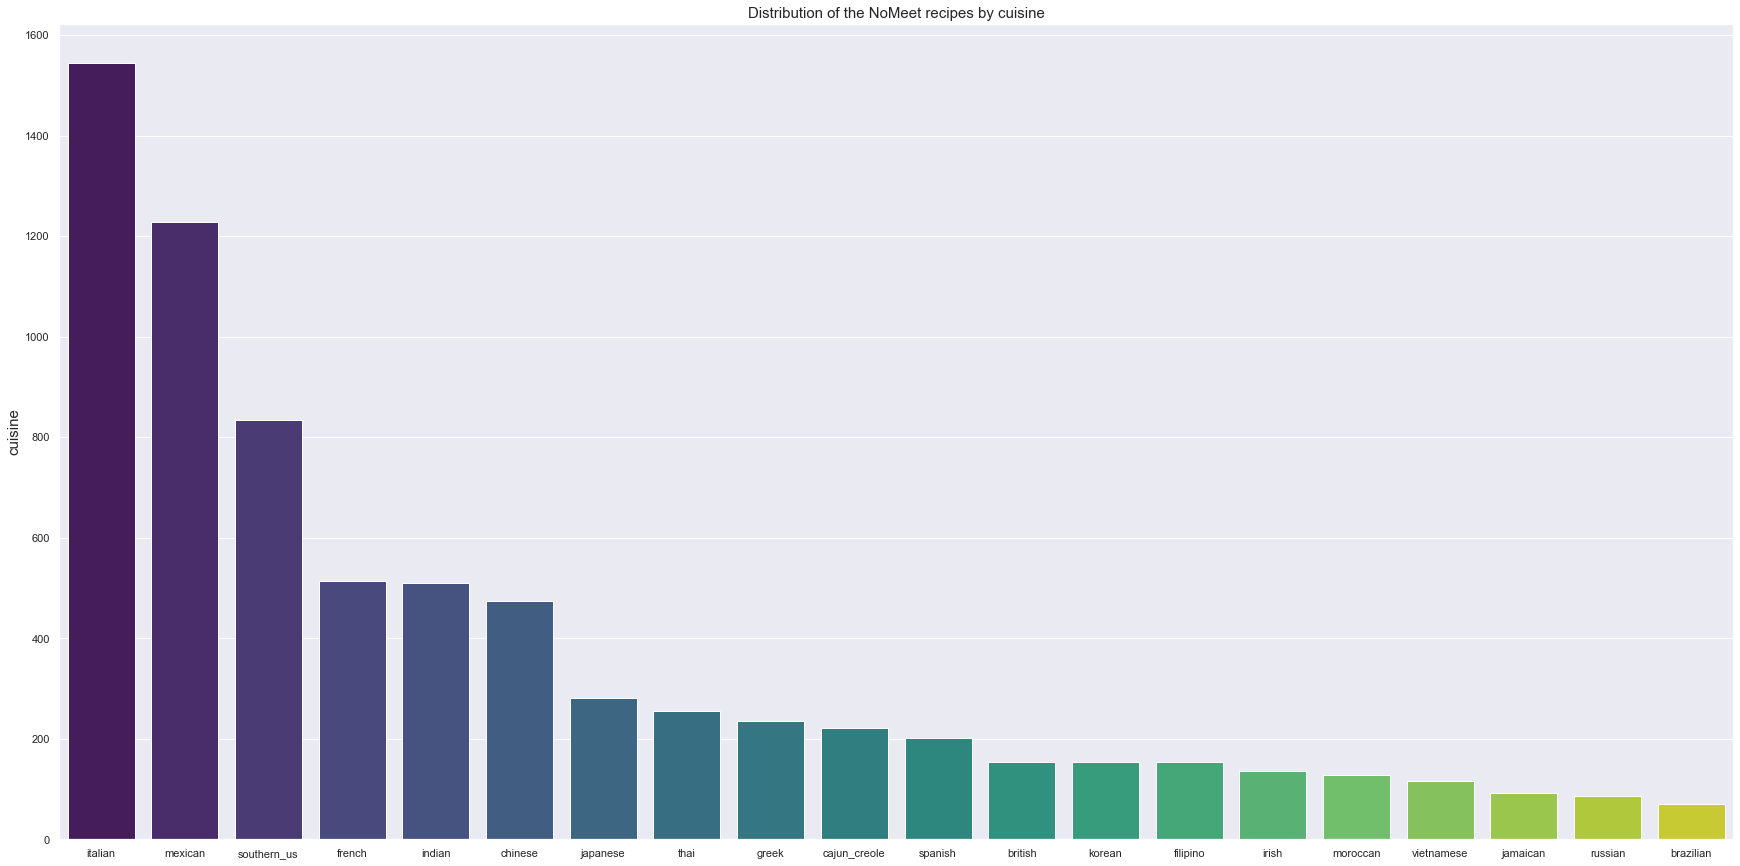

In [51]:
sns.set(rc={'figure.figsize':(30,15),
            'axes.labelsize': 15, 
            'font.size': 15, 
            'legend.fontsize': 12, 
            'axes.titlesize':15,
            'figure.facecolor': 'white',
            'font.family': ['sans-serif'],
            'legend.fancybox': True,
            'lines.color': 'C0',
            'xaxis.labellocation': 'center',
            'xtick.alignment': 'center',
            'legend.title_fontsize': 15,
            'legend.edgecolor': '0.9',
            'animation.ffmpeg_path': 'ffmpeg',
           })    

sns.barplot(nomeat['cuisine'].value_counts().index,
            nomeat['cuisine'].value_counts(),palette='viridis', ).set(title='Distribution of the NoMeet recipes by cuisine')

In [52]:
meat = df_less[df_less['meat'] != "No"]
meat.reset_index(drop=True, inplace = True)
meat.head(3)

cuisine                                        ingredients  \
0  filipino  ['eggs', 'pepper', 'salt', 'mayonaise', 'cooki...   
1  jamaican  ['plain flour', 'sugar', 'butter', 'eggs', 'fr...   
2   italian  ['sugar', 'pistachio nuts', 'white almond bark...   

                                               final  Len     meat sugar  
0  egg, pepper, salt, mayonaise, cooking oil, gre...   12  chicken    No  
1  plain flour, sugar, butter, egg, fresh ginger ...   12  chicken    No  
2  sugar, pistachio nut, white almond bark, flour...   10   shrimp    No

[Text(0.5, 1.0, 'Distribution of the Meet recipes by cuisine')]

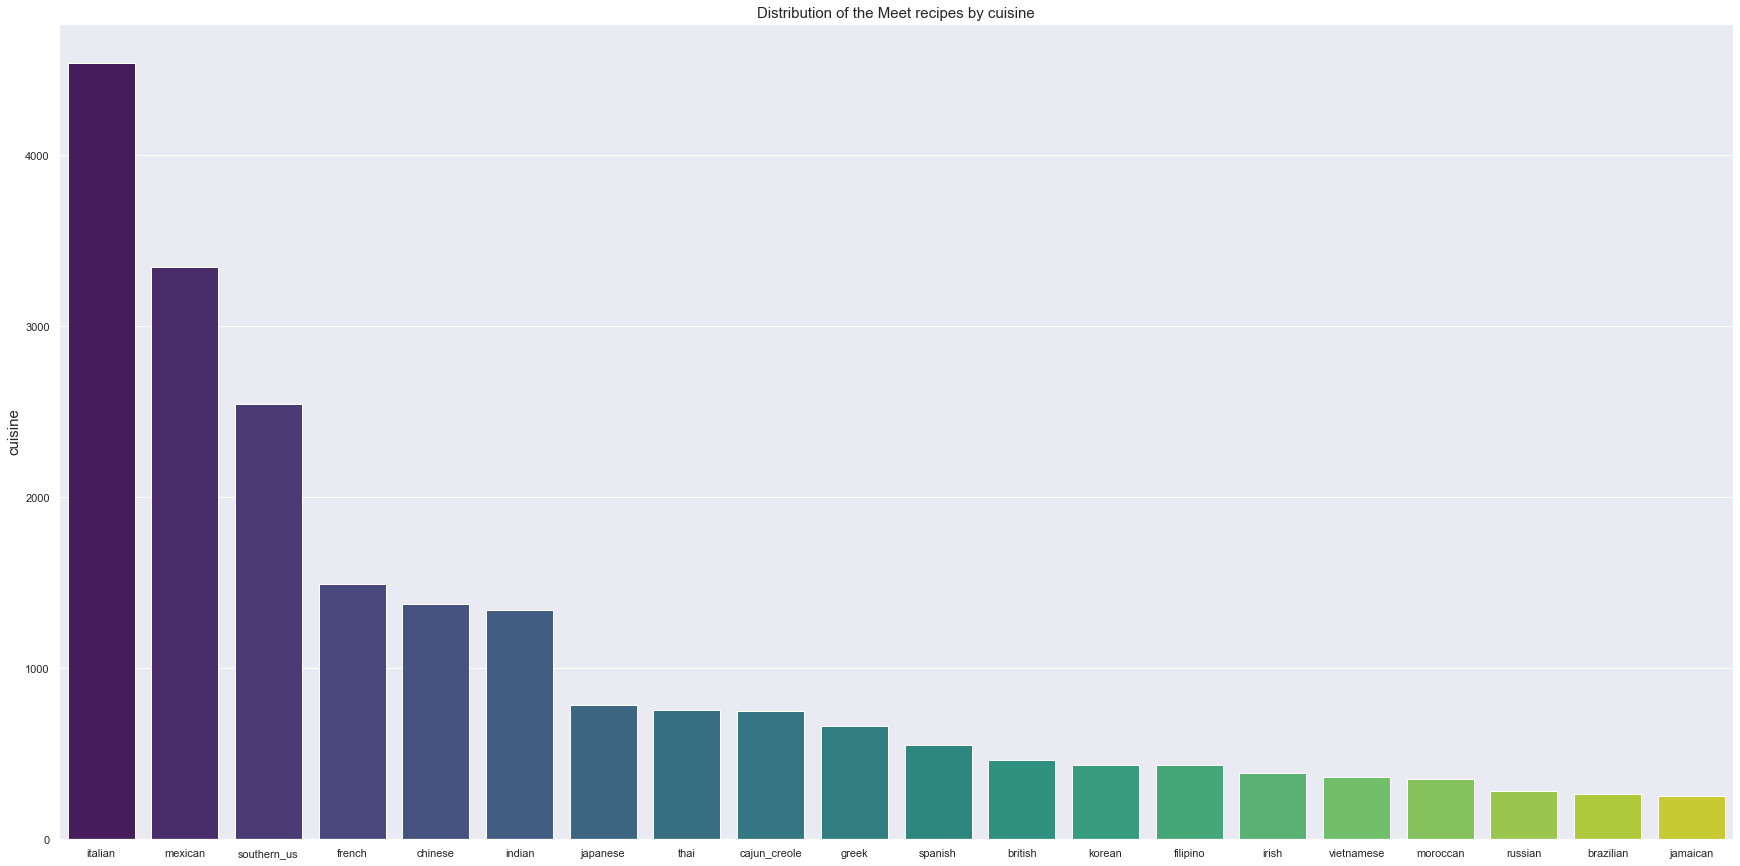

In [53]:
sns.set(rc={'figure.figsize':(30,15),
            'axes.labelsize': 15, 
            'font.size': 15, 
            'legend.fontsize': 12, 
            'axes.titlesize':15,
            'figure.facecolor': 'white',
            'font.family': ['sans-serif'],
            'legend.fancybox': True,
            'lines.color': 'C0',
            'xaxis.labellocation': 'center',
            'xtick.alignment': 'center',
            'legend.title_fontsize': 15,
            'legend.edgecolor': '0.9',
            'animation.ffmpeg_path': 'ffmpeg',
           })    

sns.barplot(meat['cuisine'].value_counts().index,
            meat['cuisine'].value_counts(),palette='viridis').set(title='Distribution of the Meet recipes by cuisine')

In [54]:
sweet = df_less[(df_less['meat'] == "No") & (df_less['sugar'] != "No")]
sweet.reset_index(drop=True, inplace = True)
sweet

cuisine                                        ingredients  \
0         spanish  ['olive oil', 'salt', 'medium shrimp', 'pepper...   
1         mexican  ['olive oil', 'purple onion', 'fresh pineapple...   
2            thai  ['sugar', 'hot chili', 'asian fish sauce', 'li...   
3     southern_us  ['green onions', 'cream cheese', 'shredded che...   
4     southern_us  ['mayonaise', 'white sugar', 'ground black pep...   
...           ...                                                ...   
5367      italian  ['spinach', 'purple onion', 'french bread', 'p...   
5368      italian  ['rosemary sprigs', 'lemon zest', 'garlic clov...   
5369       indian  ['mint leaves', 'cilantro leaves', 'ghee', 'to...   
5370       indian  ['curry powder', 'salt', 'chicken', 'water', '...   
5371      italian  ['low-fat sour cream', 'grated parmesan cheese...   

                                                  final  Len meat  sugar  
0     olive oil, salt, medium shrimp, pepper, garlic...   13   No  sugar  
1     olive oil, purple onion, fresh pineapple, pork...   13   No  sugar  
2        sugar, hot chili, asian fish sauce, lime juice    4   No  sugar  
3     green onion, cream cheese, shredded cheddar ch...    8   No  sugar  
4     mayonaise, white sugar, ground black pepper, s...    6   No  sugar  
...                                                 ...  ...  ...    ...  
5367  spinach, purple onion, french bread, plum toma...    8   No  sugar  
5368  rosemary sprig, lemon zest, garlic clove, grou...   12   No  sugar  
5369  mint leaf, cilantro leaf, ghee, tomato, cinnam...   14   No  sugar  
5370  curry powder, salt, chicken, water, vegetable ...   12   No  sugar  
5371  low fat sour cream, grated parmesan cheese, sa...   13   No  sugar  

[5372 rows x 6 columns]

# Tagging the ingredients

In [55]:
import nltk
# nltk.download('averaged_perceptron_tagger')
def preprocess(sent):
    sent = nltk.word_tokenize(sent)
    sent = nltk.pos_tag(sent)
    return sent



In [56]:
# Add a new column with the preprocess
df_less["prepros"] = df_less["final"].apply(lambda x: preprocess(x))


In [57]:
# Create a list of the adjectives
jj = []
for a in df_less["prepros"]:
    for row in a:
        if 'JJ' in row:
            jj.append(row[0])
jj

['black',
 'garlic',
 'purple',
 'garbanzo',
 'feta',
 'flour',
 'black',
 'green',
 'yellow',
 'vegetable',
 'green',
 'garlic',
 'yellow',
 'vegetable',
 'flour',
 'fresh',
 'olive',
 'garlic',
 'flat',
 'white',
 'white',
 'olive',
 'olive',
 'fresh',
 'black',
 'fresh',
 'garlic',
 'extra',
 'olive',
 'flat',
 'sweet',
 'olive',
 'sharp',
 'swiss',
 'canola',
 'black',
 'low',
 'fresh',
 'dry',
 'green',
 'white',
 'sesame',
 'canola',
 'garlic',
 'red',
 'italian',
 'hot',
 'red',
 'extra',
 'olive',
 'fresh',
 'garlic',
 'fine',
 'flat',
 'fresh',
 'fat',
 'free',
 'fresh',
 'cheese',
 'ground',
 'black',
 'fat',
 'free',
 'vegetable',
 'red',
 'red',
 'sweet',
 'greek',
 'lemon',
 'italian',
 'zesty',
 'italian',
 'hot',
 'asian',
 'lime',
 'vegetable',
 'red',
 'yellow',
 'garlic',
 'green',
 'fresh',
 'creamy',
 'fresh',
 'thai',
 'purple',
 'low',
 'red',
 'yellow',
 'extra',
 'arrowroot',
 'fresh',
 'sesame',
 'red',
 'flat',
 'olive',
 'red',
 'olive',
 'lemon',
 'lo',
 'li

In [58]:
# Create a list of the noun

nn = []
for a in df_less["prepros"]:
    for row in a:
        if 'NN' in row:
            nn.append(row[0])
nn

['romaine',
 'lettuce',
 'olive',
 'grape',
 'tomato',
 'pepper',
 'onion',
 'bean',
 'cheese',
 'ground',
 'pepper',
 'salt',
 'tomato',
 'ground',
 'pepper',
 'thyme',
 'egg',
 'tomato',
 'corn',
 'meal',
 'milk',
 'oil',
 'egg',
 'pepper',
 'salt',
 'mayonaise',
 'oil',
 'chicken',
 'breast',
 'powder',
 'onion',
 'soy',
 'sauce',
 'butter',
 'liver',
 'water',
 'oil',
 'wheat',
 'salt',
 'sugar',
 'butter',
 'egg',
 'ginger',
 'root',
 'salt',
 'ground',
 'cinnamon',
 'milk',
 'vanilla',
 'extract',
 'ground',
 'ginger',
 'sugar',
 'powder',
 'oil',
 'salt',
 'medium',
 'shrimp',
 'pepper',
 'cilantro',
 'jalapeno',
 'leaf',
 'parsley',
 'skirt',
 'steak',
 'vinegar',
 'sea',
 'salt',
 'bay',
 'leaf',
 'chorizo',
 'sausage',
 'sugar',
 'pistachio',
 'nut',
 'almond',
 'bark',
 'flour',
 'vanilla',
 'extract',
 'oil',
 'almond',
 'extract',
 'egg',
 'powder',
 'cranberry',
 'oil',
 'purple',
 'onion',
 'pineapple',
 'pork',
 'poblano',
 'pepper',
 'corn',
 'tortilla',
 'cheddar',
 '

In [59]:
vocabjj = Counter(jj)
vocabnn = Counter(nn)

In [60]:
vocabjj.most_common(15)

[('fresh', 12249),
 ('garlic', 11496),
 ('olive', 9532),
 ('black', 7929),
 ('red', 6580),
 ('green', 6272),
 ('white', 6256),
 ('large', 4553),
 ('vegetable', 4361),
 ('extra', 2611),
 ('unsalted', 2495),
 ('dry', 2445),
 ('parmesan', 2073),
 ('lemon', 2070),
 ('low', 1742)]

In [61]:
vocabnn.most_common(15)

[('salt', 19532),
 ('pepper', 19315),
 ('oil', 18231),
 ('onion', 14041),
 ('ground', 12488),
 ('sugar', 10448),
 ('sauce', 9880),
 ('cheese', 9595),
 ('tomato', 7860),
 ('water', 7598),
 ('egg', 7595),
 ('butter', 7295),
 ('powder', 5924),
 ('clove', 5866),
 ('chicken', 5587)]

In [62]:
df_less

cuisine                                        ingredients  \
0            greek  ['romaine lettuce', 'black olives', 'grape tom...   
1      southern_us  ['plain flour', 'ground pepper', 'salt', 'toma...   
2         filipino  ['eggs', 'pepper', 'salt', 'mayonaise', 'cooki...   
3           indian        ['water', 'vegetable oil', 'wheat', 'salt']   
4         jamaican  ['plain flour', 'sugar', 'butter', 'eggs', 'fr...   
...            ...                                                ...   
34146      mexican  ['shredded cheddar cheese', 'crushed cheese cr...   
34147        irish  ['light brown sugar', 'granulated sugar', 'but...   
34148      italian  ['KRAFT Zesty Italian Dressing', 'purple onion...   
34149        irish  ['eggs', 'citrus fruit', 'raisins', 'sourdough...   
34150      mexican  ['green chile', 'jalapeno chilies', 'onions', ...   

                                                   final  Len     meat  sugar  \
0      romaine lettuce, black olive, grape tomato, ga...    9       No     No   
1      plain flour, ground pepper, salt, tomato, grou...   11       No     No   
2      egg, pepper, salt, mayonaise, cooking oil, gre...   12  chicken     No   
3                      water, vegetable oil, wheat, salt    4       No     No   
4      plain flour, sugar, butter, egg, fresh ginger ...   12  chicken     No   
...                                                  ...  ...      ...    ...   
34146  shredded cheddar cheese, crushed cheese cracke...   10     pork  sugar   
34147  light brown sugar, granulated sugar, butter, w...   12       No     No   
34148  kraft zesty italian dressing, purple onion, br...    7   kosher     No   
34149  egg, citrus fruit, raisin, sourdough starter, ...   12     chop     No   
34150  green chile, jalapeno chilies, onion, ground b...   12       No     No   

                                                 prepros  
0      [(romaine, NN), (lettuce, NN), (,, ,), (black,...  
1      [(plain, RB), (flour, JJ), (,, ,), (ground, NN...  
2      [(egg, NN), (,, ,), (pepper, NN), (,, ,), (sal...  
3      [(water, NN), (,, ,), (vegetable, JJ), (oil, N...  
4      [(plain, RB), (flour, JJ), (,, ,), (sugar, NN)...  
...                                                  ...  
34146  [(shredded, VBN), (cheddar, NN), (cheese, NN),...  
34147  [(light, JJ), (brown, NN), (sugar, NN), (,, ,)...  
34148  [(kraft, NN), (zesty, NN), (italian, JJ), (dre...  
34149  [(egg, NN), (,, ,), (citrus, NN), (fruit, NN),...  
34150  [(green, JJ), (chile, NN), (,, ,), (jalapeno, ...  

[34151 rows x 7 columns]

# Searching for Brands

In [63]:
import spacy
from spacy import displacy
from collections import Counter

## Spanish corpus (https://spacy.io/models/es#es_core_news_md)
# python -m spacy download es
import es_core_news_sm
nlp_sp = es_core_news_sm.load()
nlp_sp

## English corpus
#python -m spacy download en
import en_core_web_sm
nlp = en_core_web_sm.load()
nlp

In [64]:
df_less["prepros2"] = df_less["final"].apply(lambda x: nlp(x))

In [65]:
# Create a list of the brands
a=[]
for row in df_less["final"]:
    doc = nlp(row)
    a += [(X.text, X.label_) for X in doc.ents]

In [66]:
a

[('romaine lettuce', 'PERSON'),
 ('grape tomato', 'PERSON'),
 ('green tomato', 'PERSON'),
 ('cilantro', 'GPE'),
 ('flat leaf parsley', 'ORG'),
 ('skirt steak', 'ORG'),
 ('white vinegar', 'ORG'),
 ('sea salt', 'GPE'),
 ('bay leaf', 'ORG'),
 ('pistachio nut', 'PERSON'),
 ('white almond bark', 'ORG'),
 ('flour', 'PERSON'),
 ('jalapeno chilies', 'PERSON'),
 ('cilantro', 'GPE'),
 ('kosher salt', 'ORG'),
 ('swiss', 'NORP'),
 ('canola', 'PRODUCT'),
 ('fresh ginger', 'PERSON'),
 ('green bean', 'ORG'),
 ('canola', 'PRODUCT'),
 ('turkey', 'GPE'),
 ('italian', 'NORP'),
 ('garlic clove', 'PERSON'),
 ('chipotle chile', 'PERSON'),
 ('parmesan cheese', 'ORG'),
 ('fat free le sodium chicken', 'ORG'),
 ('gruyere cheese', 'PERSON'),
 ('bacon slice', 'GPE'),
 ('gnocchi', 'GPE'),
 ('tomato', 'ORG'),
 ('garam masala', 'PERSON'),
 ('naan', 'GPE'),
 ('red chili', 'NORP'),
 ('greek', 'NORP'),
 ('confectioner sugar', 'PERSON'),
 ('italian', 'NORP'),
 ('broiler fryer chicken', 'PERSON'),
 ('mayonaise', 'ORG'),


In [67]:
print([(X) for X in a if 'ORG' in X])

[('flat leaf parsley', 'ORG'), ('skirt steak', 'ORG'), ('white vinegar', 'ORG'), ('bay leaf', 'ORG'), ('white almond bark', 'ORG'), ('kosher salt', 'ORG'), ('green bean', 'ORG'), ('parmesan cheese', 'ORG'), ('fat free le sodium chicken', 'ORG'), ('tomato', 'ORG'), ('mayonaise', 'ORG'), ('red bell pepper', 'ORG'), ('broccoli', 'ORG'), ('orange bell pepper', 'ORG'), ('flat leaf parsley', 'ORG'), ('chile pepper', 'ORG'), ('red chili pepper', 'ORG'), ('parmesan cheese', 'ORG'), ('flour', 'ORG'), ('parmesan cheese', 'ORG'), ('chili powder', 'ORG'), ('garlic powder', 'ORG'), ('tomato', 'ORG'), ('chili powder', 'ORG'), ('collard green', 'ORG'), ('apple cider', 'ORG'), ('chile powder', 'ORG'), ('bay leaf', 'ORG'), ('ice cube', 'ORG'), ('white rum', 'ORG'), ('tomato', 'ORG'), ('white vinegar', 'ORG'), ('avocado', 'ORG'), ('egg', 'ORG'), ('white vinegar', 'ORG'), ('bay leaf', 'ORG'), ('basil', 'ORG'), ('tomato', 'ORG'), ('coarse salt', 'ORG'), ('tomato', 'ORG'), ('red bell pepper', 'ORG'), ('car

# Vectorizer and Clustering

## Clustering without a Cuisine Type

In [68]:
count_vectorizer = CountVectorizer()
train_vectors = count_vectorizer.fit_transform(df_less['final'])

train_vectors

a = train_vectors.todense()

unidades_datos = np.array(a)
unidades_datos


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [69]:
# I transform the array into a DF 
new_df = pd.DataFrame(unidades_datos)
new_df

0     1     2     3     4     5     6     7     8     9     ...  2675  \
0         0     0     0     0     0     0     0     0     0     0  ...     0   
1         0     0     0     0     0     0     0     0     0     0  ...     0   
2         0     0     0     0     0     0     0     0     0     0  ...     0   
3         0     0     0     0     0     0     0     0     0     0  ...     0   
4         0     0     0     0     0     0     0     0     0     0  ...     0   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
34146     0     0     0     0     0     0     0     0     0     0  ...     0   
34147     0     0     0     0     0     0     0     0     0     0  ...     0   
34148     0     0     0     0     0     0     0     0     0     0  ...     0   
34149     0     0     0     0     0     0     0     0     0     0  ...     0   
34150     0     0     0     0     0     0     0     0     0     0  ...     0   

       2676  2677  2678  2679  2680  2681  2682  2683  2684  
0         0     0     0     0     0     0     0     0     0  
1         0     0     0     0     0     0     0     0     0  
2         0     0     0     0     0     0     0     0     0  
3         0     0     0     0     0     0     0     0     0  
4         0     0     0     0     0     0     0     0     0  
...     ...   ...   ...   ...   ...   ...   ...   ...   ...  
34146     0     0     0     0     0     0     0     0     0  
34147     0     0     0     0     0     0     0     0     0  
34148     0     0     0     0     0     1     0     0     0  
34149     0     0     0     0     0     0     0     0     0  
34150     0     0     0     0     0     0     0     0     0  

[34151 rows x 2685 columns]

In [70]:
from sklearn.cluster import KMeans
inertia =[]

In [71]:
###Static code to get max no of clusters

for i in range(1,10):
    kmeans = KMeans(n_clusters= i,random_state = 43)
    kmeans.fit(new_df)
    inertia.append(kmeans.inertia_)

In [72]:
from kneed import KneeLocator
kl = KneeLocator(range(1, 10), inertia, curve="convex", direction="decreasing")
print('The elbow point of your model is:', kl.elbow)

The elbow point of your model is: 4


In [73]:
kmeansmodel = KMeans(n_clusters= 4, random_state=0)
y_kmeans= kmeansmodel.fit_predict(new_df)

In [74]:
# Create a new column with the cluster id
df_less['cluster_id'] = y_kmeans
df_less

cuisine                                        ingredients  \
0            greek  ['romaine lettuce', 'black olives', 'grape tom...   
1      southern_us  ['plain flour', 'ground pepper', 'salt', 'toma...   
2         filipino  ['eggs', 'pepper', 'salt', 'mayonaise', 'cooki...   
3           indian        ['water', 'vegetable oil', 'wheat', 'salt']   
4         jamaican  ['plain flour', 'sugar', 'butter', 'eggs', 'fr...   
...            ...                                                ...   
34146      mexican  ['shredded cheddar cheese', 'crushed cheese cr...   
34147        irish  ['light brown sugar', 'granulated sugar', 'but...   
34148      italian  ['KRAFT Zesty Italian Dressing', 'purple onion...   
34149        irish  ['eggs', 'citrus fruit', 'raisins', 'sourdough...   
34150      mexican  ['green chile', 'jalapeno chilies', 'onions', ...   

                                                   final  Len     meat  sugar  \
0      romaine lettuce, black olive, grape tomato, ga...    9       No     No   
1      plain flour, ground pepper, salt, tomato, grou...   11       No     No   
2      egg, pepper, salt, mayonaise, cooking oil, gre...   12  chicken     No   
3                      water, vegetable oil, wheat, salt    4       No     No   
4      plain flour, sugar, butter, egg, fresh ginger ...   12  chicken     No   
...                                                  ...  ...      ...    ...   
34146  shredded cheddar cheese, crushed cheese cracke...   10     pork  sugar   
34147  light brown sugar, granulated sugar, butter, w...   12       No     No   
34148  kraft zesty italian dressing, purple onion, br...    7   kosher     No   
34149  egg, citrus fruit, raisin, sourdough starter, ...   12     chop     No   
34150  green chile, jalapeno chilies, onion, ground b...   12       No     No   

                                                 prepros  \
0      [(romaine, NN), (lettuce, NN), (,, ,), (black,...   
1      [(plain, RB), (flour, JJ), (,, ,), (ground, NN...   
2      [(egg, NN), (,, ,), (pepper, NN), (,, ,), (sal...   
3      [(water, NN), (,, ,), (vegetable, JJ), (oil, N...   
4      [(plain, RB), (flour, JJ), (,, ,), (sugar, NN)...   
...                                                  ...   
34146  [(shredded, VBN), (cheddar, NN), (cheese, NN),...   
34147  [(light, JJ), (brown, NN), (sugar, NN), (,, ,)...   
34148  [(kraft, NN), (zesty, NN), (italian, JJ), (dre...   
34149  [(egg, NN), (,, ,), (citrus, NN), (fruit, NN),...   
34150  [(green, JJ), (chile, NN), (,, ,), (jalapeno, ...   

                                                prepros2  cluster_id  
0      (romaine, lettuce, ,, black, olive, ,, grape, ...           3  
1      (plain, flour, ,, ground, pepper, ,, salt, ,, ...           2  
2      (egg, ,, pepper, ,, salt, ,, mayonaise, ,, coo...           0  
3          (water, ,, vegetable, oil, ,, wheat, ,, salt)           3  
4      (plain, flour, ,, sugar, ,, butter, ,, egg, ,,...           1  
...                                                  ...         ...  
34146  (shredded, cheddar, cheese, ,, crushed, cheese...           3  
34147  (light, brown, sugar, ,, granulated, sugar, ,,...           1  
34148  (kraft, zesty, italian, dressing, ,, purple, o...           3  
34149  (egg, ,, citrus, fruit, ,, raisin, ,, sourdoug...           1  
34150  (green, chile, ,, jalapeno, chilies, ,, onion,...           2  

[34151 rows x 9 columns]

In [75]:
df_less['cluster_id'].value_counts()

3    13642
2    11202
1     4804
0     4503
Name: cluster_id, dtype: int64

In [76]:
# Save as a new Data
df_less.to_csv('../dataset/01-Data_Clean.csv')

In [77]:
# Check the cluster 2
c2= df_less[df_less['cluster_id'] == 2]
c2['cuisine'].value_counts()

italian         3688
mexican         1888
indian           885
southern_us      868
french           691
greek            628
cajun_creole     626
spanish          498
moroccan         370
jamaican         177
thai             140
filipino         125
brazilian        121
irish            101
british           87
russian           85
chinese           81
japanese          57
vietnamese        53
korean            33
Name: cuisine, dtype: int64

In [78]:
c2.groupby(['cuisine'])["Len"].describe()

count       mean       std  min   25%   50%   75%   max
cuisine                                                               
brazilian      121.0  12.074380  2.284605  6.0  11.0  12.0  14.0  15.0
british         87.0  11.885057  2.222639  6.0  10.0  12.0  14.0  15.0
cajun_creole   626.0  11.926518  2.286174  4.0  10.0  12.0  14.0  15.0
chinese         81.0  10.617284  2.272487  4.0   9.0  11.0  12.0  15.0
filipino       125.0  10.584000  2.369783  4.0   9.0  11.0  12.0  15.0
french         691.0  10.995658  2.563678  4.0   9.0  11.0  13.0  15.0
greek          628.0  10.767516  2.409463  4.0   9.0  11.0  12.0  15.0
indian         885.0  12.310734  2.108362  5.0  11.0  13.0  14.0  15.0
irish          101.0  11.346535  2.355571  5.0  10.0  11.0  13.0  15.0
italian       3688.0  10.698482  2.424936  3.0   9.0  11.0  13.0  15.0
jamaican       177.0  11.830508  2.149148  7.0  10.0  12.0  14.0  15.0
japanese        57.0  11.350877  2.030932  7.0  10.0  11.0  13.0  15.0
korean          33.0  10.424242  2.646109  4.0   9.0  11.0  12.0  15.0
mexican       1888.0  11.663136  2.341053  5.0  10.0  12.0  14.0  15.0
moroccan       370.0  11.843243  2.401957  5.0  10.0  12.0  14.0  15.0
russian         85.0  11.223529  2.306185  7.0   9.0  11.0  13.0  15.0
southern_us    868.0  10.892857  2.460070  4.0   9.0  11.0  13.0  15.0
spanish        498.0  10.909639  2.659380  4.0   9.0  11.0  13.0  15.0
thai           140.0  11.885714  2.260342  7.0  10.0  12.0  14.0  15.0
vietnamese      53.0  11.169811  2.501814  6.0  10.0  12.0  13.0  15.0

In [79]:
c1= df_less[df_less['cluster_id'] == 1]
c2= df_less[df_less['cluster_id'] == 2]
c3= df_less[df_less['cluster_id'] == 3]
c0= df_less[df_less['cluster_id'] == 0]

In [84]:
from wordcloud import WordCloud, STOPWORDS
# wrap the plotting in a function for easier access
def plot_wordcloud(wordcloud, language):
    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.title(language + ' Comments\n', fontsize=18, fontweight='bold')
    plt.show()

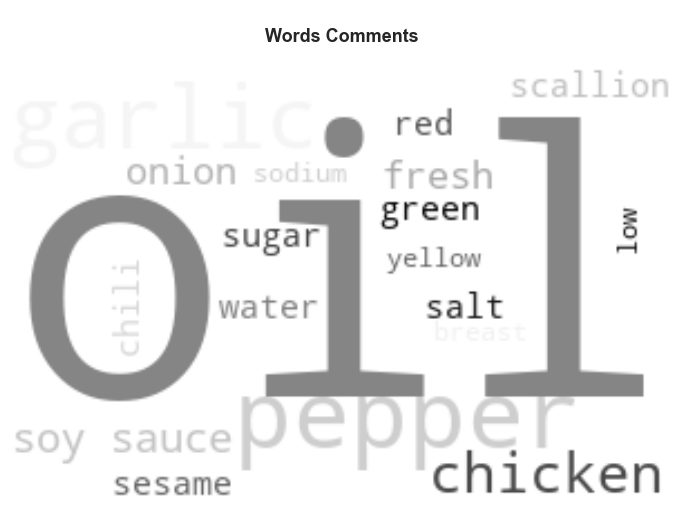

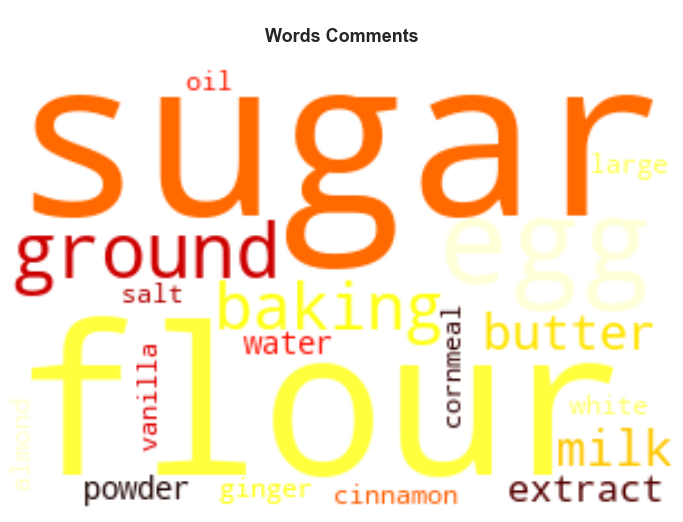

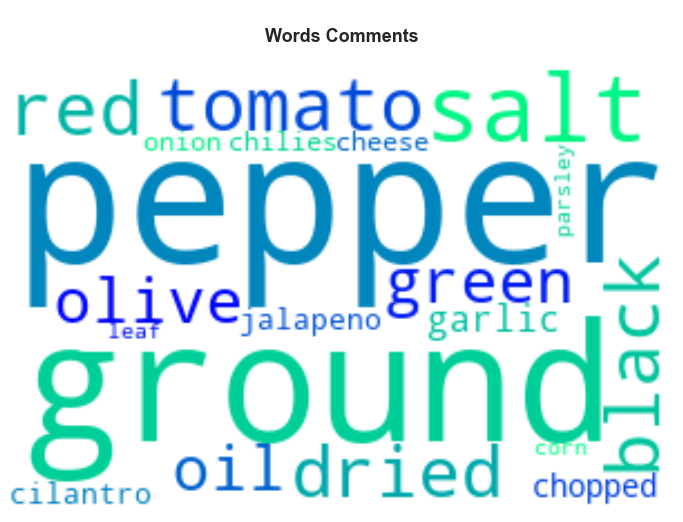

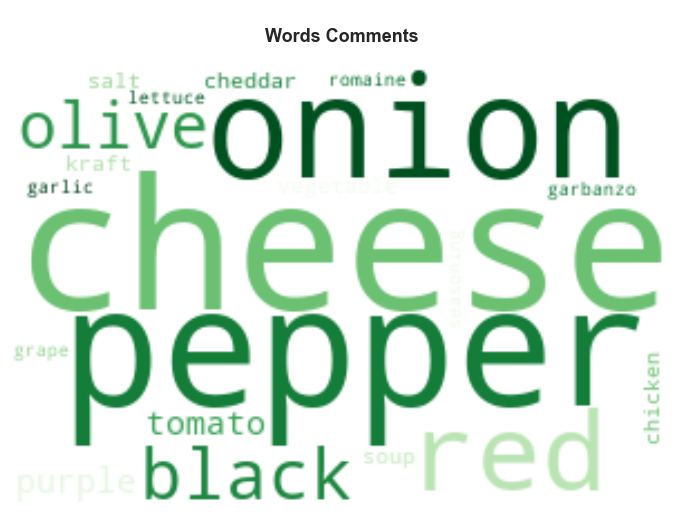

In [85]:
wordcloud = WordCloud(max_font_size=200, max_words=20, background_color="white",
                      
                      width= 300, height = 200,
                      stopwords = stopwords.words('english')).generate(str(c0.final.values))

plot_wordcloud(wordcloud.recolor( colormap= 'gray' , random_state=17), '\nWords')
wordcloud = WordCloud(max_font_size=200, max_words=20, background_color="white",
                      
                      width= 300, height = 200,
                      stopwords = stopwords.words('english')).generate(str(c1.final.values))

plot_wordcloud(wordcloud.recolor( colormap= 'hot' , random_state=17), '\nWords')
wordcloud = WordCloud(max_font_size=200, max_words=20, background_color="white",
                      
                      width= 300, height = 200,
                      stopwords = stopwords.words('english')).generate(str(c2.final.values))

plot_wordcloud(wordcloud.recolor( colormap= 'winter' , random_state=17), '\nWords')
wordcloud = WordCloud(max_font_size=200, max_words=20, background_color="white",
                      
                      width= 300, height = 200,
                      stopwords = stopwords.words('english')).generate(str(c3.final.values))

plot_wordcloud(wordcloud.recolor( colormap= 'Greens' , random_state=17), '\nWords')

## Clustering with cuisine

In [86]:
from sklearn.preprocessing import LabelEncoder
# Step 1. Instantiate the model (label encoding)
lb_make = LabelEncoder() 

# Step 2. Fit the variable to the instatiated model
new_df['Country'] = lb_make.fit_transform(df_less['cuisine'])

new_df

0  1  2  3  4  5  6  7  8  9  ...  2676  2677  2678  2679  2680  2681  \
0      0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
1      0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
2      0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
3      0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
4      0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
...   .. .. .. .. .. .. .. .. .. ..  ...   ...   ...   ...   ...   ...   ...   
34146  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
34147  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
34148  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     1   
34149  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
34150  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   

       2682  2683  2684  Country  
0         0     0     0        6  
1         0     0     0       16  
2         0     0     0        4  
3         0     0     0        7  
4         0     0     0       10  
...     ...   ...   ...      ...  
34146     0     0     0       13  
34147     0     0     0        8  
34148     0     0     0        9  
34149     0     0     0        8  
34150     0     0     0       13  

[34151 rows x 2686 columns]

In [87]:
new_df.Country.value_counts()

9     7238
13    5439
16    3988
5     2389
3     2198
7     2181
11    1276
18    1194
2     1146
6     1065
17     880
1      732
12     716
4      692
8      629
19     578
14     569
15     434
0      404
10     403
Name: Country, dtype: int64

In [88]:
from sklearn import preprocessing 

X = new_df

scaler = preprocessing.MinMaxScaler()
scaler

df_sc = scaler.fit_transform(X)
df_sc

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.31578947],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.84210526],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.21052632],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.47368421],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.42105263],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.68421053]])

In [89]:
from sklearn.cluster import KMeans
inertia =[]

###Static code to get max no of clusters

for i in range(1,10):
    kmeans = KMeans(n_clusters= i,random_state = 43)
    kmeans.fit(new_df)
    inertia.append(kmeans.inertia_)

In [90]:
df_sc = pd.DataFrame(df_sc, columns = X.columns) 

In [91]:
from kneed import KneeLocator
kl = KneeLocator(range(1, 10), inertia, curve="convex", direction="decreasing")
print('The elbow point of your model is:', kl.elbow)

The elbow point of your model is: 3


In [92]:
kmeansmodel = KMeans(n_clusters= 3, random_state=0)
y_kmeans= kmeansmodel.fit_predict(df_sc)

In [93]:
df_less['cluster_id'] = y_kmeans
df_less

cuisine                                        ingredients  \
0            greek  ['romaine lettuce', 'black olives', 'grape tom...   
1      southern_us  ['plain flour', 'ground pepper', 'salt', 'toma...   
2         filipino  ['eggs', 'pepper', 'salt', 'mayonaise', 'cooki...   
3           indian        ['water', 'vegetable oil', 'wheat', 'salt']   
4         jamaican  ['plain flour', 'sugar', 'butter', 'eggs', 'fr...   
...            ...                                                ...   
34146      mexican  ['shredded cheddar cheese', 'crushed cheese cr...   
34147        irish  ['light brown sugar', 'granulated sugar', 'but...   
34148      italian  ['KRAFT Zesty Italian Dressing', 'purple onion...   
34149        irish  ['eggs', 'citrus fruit', 'raisins', 'sourdough...   
34150      mexican  ['green chile', 'jalapeno chilies', 'onions', ...   

                                                   final  Len     meat  sugar  \
0      romaine lettuce, black olive, grape tomato, ga...    9       No     No   
1      plain flour, ground pepper, salt, tomato, grou...   11       No     No   
2      egg, pepper, salt, mayonaise, cooking oil, gre...   12  chicken     No   
3                      water, vegetable oil, wheat, salt    4       No     No   
4      plain flour, sugar, butter, egg, fresh ginger ...   12  chicken     No   
...                                                  ...  ...      ...    ...   
34146  shredded cheddar cheese, crushed cheese cracke...   10     pork  sugar   
34147  light brown sugar, granulated sugar, butter, w...   12       No     No   
34148  kraft zesty italian dressing, purple onion, br...    7   kosher     No   
34149  egg, citrus fruit, raisin, sourdough starter, ...   12     chop     No   
34150  green chile, jalapeno chilies, onion, ground b...   12       No     No   

                                                 prepros  \
0      [(romaine, NN), (lettuce, NN), (,, ,), (black,...   
1      [(plain, RB), (flour, JJ), (,, ,), (ground, NN...   
2      [(egg, NN), (,, ,), (pepper, NN), (,, ,), (sal...   
3      [(water, NN), (,, ,), (vegetable, JJ), (oil, N...   
4      [(plain, RB), (flour, JJ), (,, ,), (sugar, NN)...   
...                                                  ...   
34146  [(shredded, VBN), (cheddar, NN), (cheese, NN),...   
34147  [(light, JJ), (brown, NN), (sugar, NN), (,, ,)...   
34148  [(kraft, NN), (zesty, NN), (italian, JJ), (dre...   
34149  [(egg, NN), (,, ,), (citrus, NN), (fruit, NN),...   
34150  [(green, JJ), (chile, NN), (,, ,), (jalapeno, ...   

                                                prepros2  cluster_id  
0      (romaine, lettuce, ,, black, olive, ,, grape, ...           1  
1      (plain, flour, ,, ground, pepper, ,, salt, ,, ...           0  
2      (egg, ,, pepper, ,, salt, ,, mayonaise, ,, coo...           1  
3          (water, ,, vegetable, oil, ,, wheat, ,, salt)           0  
4      (plain, flour, ,, sugar, ,, butter, ,, egg, ,,...           0  
...                                                  ...         ...  
34146  (shredded, cheddar, cheese, ,, crushed, cheese...           1  
34147  (light, brown, sugar, ,, granulated, sugar, ,,...           0  
34148  (kraft, zesty, italian, dressing, ,, purple, o...           1  
34149  (egg, ,, citrus, fruit, ,, raisin, ,, sourdoug...           0  
34150  (green, chile, ,, jalapeno, chilies, ,, onion,...           1  

[34151 rows x 9 columns]

In [94]:
df_less.to_csv('../dataset/03-Data_Clean.csv')

In [95]:
c1= df_less[df_less['cluster_id'] == 1]
c2= df_less[df_less['cluster_id'] == 2]
c3= df_less[df_less['cluster_id'] == 3]
c0= df_less[df_less['cluster_id'] == 0]

# Topic Modeling

In [96]:
text_list = [i.split(' ') for i in df_less.final if i != ',']

In [97]:
text_list

[['romaine',
  'lettuce,',
  'black',
  'olive,',
  'grape',
  'tomato,',
  'garlic,',
  'pepper,',
  'purple',
  'onion,',
  'seasoning,',
  'garbanzo',
  'bean,',
  'feta',
  'cheese',
  'crumbles'],
 ['plain',
  'flour,',
  'ground',
  'pepper,',
  'salt,',
  'tomato,',
  'ground',
  'black',
  'pepper,',
  'thyme,',
  'egg,',
  'green',
  'tomato,',
  'yellow',
  'corn',
  'meal,',
  'milk,',
  'vegetable',
  'oil'],
 ['egg,',
  'pepper,',
  'salt,',
  'mayonaise,',
  'cooking',
  'oil,',
  'green',
  'chilies,',
  'grilled',
  'chicken',
  'breast,',
  'garlic',
  'powder,',
  'yellow',
  'onion,',
  'soy',
  'sauce,',
  'butter,',
  'chicken',
  'liver'],
 ['water,', 'vegetable', 'oil,', 'wheat,', 'salt'],
 ['plain',
  'flour,',
  'sugar,',
  'butter,',
  'egg,',
  'fresh',
  'ginger',
  'root,',
  'salt,',
  'ground',
  'cinnamon,',
  'milk,',
  'vanilla',
  'extract,',
  'ground',
  'ginger,',
  'powdered',
  'sugar,',
  'baking',
  'powder'],
 ['olive',
  'oil,',
  'salt,',
  

In [98]:
text_list = [i for i in text_list if i != ',' or ', ']
#[variable_name for variable_name in original_list if condition

In [99]:
# Step 1. Build our own dictionary, and save it for future use
# Importing Gensim
import gensim
from gensim import corpora

# Creating the term dictionary of our courpus, 
# where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
dictionary = corpora.Dictionary(text_list)#
dictionary.save('dictionary.dict')
print (dictionary)

Dictionary(3712 unique tokens: ['bean,', 'black', 'cheese', 'crumbles', 'feta']...)


In [100]:
# Step 2. Vectorize the characters

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in text_list]


In [101]:
# Step 2.2. Create and save the gensim Corpus from the processed dictionary
corpora.MmCorpus.serialize('corpus_s.mm', doc_term_matrix)

print (len(doc_term_matrix))
print (doc_term_matrix[100])

34151
[(6, 1), (11, 2), (25, 1), (30, 1), (31, 1), (38, 1), (40, 1), (41, 1), (50, 1), (54, 1), (63, 1), (72, 1), (108, 1), (110, 1), (139, 1), (179, 2), (201, 1), (315, 1), (495, 1), (496, 1), (497, 1), (498, 1), (499, 1)]


In [102]:
# Step 3. Perform the LDA model
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=10, id2word = dictionary, 
               passes=50)

In [103]:
ldamodel.print_topics(num_topics= 10, num_words = 19)

[(0,
  '0.073*"sauce," + 0.047*"oil," + 0.041*"soy" + 0.033*"sugar," + 0.028*"sesame" + 0.023*"onion," + 0.023*"ginger," + 0.022*"garlic," + 0.021*"rice" + 0.020*"pepper," + 0.019*"green" + 0.018*"fresh" + 0.017*"red" + 0.017*"vinegar," + 0.017*"water," + 0.015*"salt," + 0.014*"fish" + 0.014*"vegetable" + 0.014*"garlic"'),
 (1,
  '0.052*"ground" + 0.045*"salt," + 0.035*"pepper," + 0.035*"onion," + 0.032*"oil," + 0.031*"powder," + 0.028*"chopped" + 0.026*"cilantro" + 0.021*"tomato," + 0.020*"fresh" + 0.020*"cumin," + 0.019*"garlic" + 0.019*"chili" + 0.019*"chilies," + 0.017*"black" + 0.016*"garlic," + 0.016*"cilantro," + 0.015*"green" + 0.014*"lime"'),
 (2,
  '0.069*"cheese," + 0.041*"parmesan" + 0.041*"fresh" + 0.039*"grated" + 0.030*"pepper," + 0.030*"salt," + 0.029*"butter," + 0.026*"oil," + 0.024*"olive" + 0.020*"dry" + 0.019*"ground" + 0.019*"garlic" + 0.017*"leaf" + 0.017*"white" + 0.017*"flat" + 0.016*"black" + 0.016*"wine," + 0.016*"parsley," + 0.015*"bread"'),
 (3,
  '0.067*"ol

In [104]:
## Let's save the model for the future 
ldamodel.save('topic.model')
## load saved model
from gensim.models import LdaModel
model_loaded = LdaModel.load('topic.model')

In [105]:
import pyLDAvis.gensim
import gensim
pyLDAvis.enable_notebook()

d = gensim.corpora.Dictionary.load('dictionary.dict')
c = gensim.corpora.MmCorpus('corpus_s.mm')
lda = gensim.models.LdaModel.load('topic.model')


data = pyLDAvis.gensim.prepare(lda, c, d)

In [106]:
data

d:\anaconda\envs\dataanalytic\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.184285  0.017211       1        1  15.079552
0      0.094049 -0.007371       2        1  14.154262
5     -0.087904 -0.120860       3        1  13.955298
1      0.185588 -0.004490       4        1  13.676134
9      0.145981  0.099236       5        1  11.438717
2      0.131495 -0.041569       6        1   9.504269
7      0.045729  0.127745       7        1   8.296057
8     -0.356268  0.243001       8        1   5.701944
6     -0.185112 -0.368656       9        1   5.248403
4     -0.157842  0.055754      10        1   2.945365, topic_info=        Term          Freq         Total Category  logprob  loglift
31   chicken   7758.000000   7758.000000  Default  30.0000  30.0000
40    sauce,   9499.000000   9499.000000  Default  29.0000  29.0000
81   cheese,   8456.000000   8456.000000  Default  28.0000  28.0000
124    lemon   4074.000000   4074.000000  Default  27.0000  27.0000
48     fresh  12317.000000  12317.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
104   flake,    185.166474   1427.789102  Topic10  -4.5860   1.4823
54    sugar,    266.879769   9898.482969  Topic10  -4.2205  -0.0884
183    brown    196.095535   2361.529410  Topic10  -4.5287   1.0365
108      red    220.473595   6682.935590  Topic10  -4.4115   0.1134
25     salt,    208.852220  16100.180483  Topic10  -4.4656  -0.8200

[622 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
345       8  0.991586        1
490       6  0.991643        2
1190      3  0.998416   active
796       4  0.985256   adobo,
1157      6  0.993742  alfredo
...     ...       ...      ...
912       2  0.989932     yolk
375       3  0.999174    yolk,
349       1  0.990268    yukon
1196      1  0.989866     zest
199       9  0.998365    zest,

[901 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 6, 2, 10, 3, 8, 9, 7, 5])

# WordCloud

In [107]:
italian = df_less[df_less.cuisine == "italian"]
mexican = df_less[df_less.cuisine == "mexican"]
southern_us = df_less[df_less.cuisine == "southern_us"]
indian = df_less[df_less.cuisine == "indian"]
chinese = df_less[df_less.cuisine == "chinese"]
french = df_less[df_less.cuisine == "french"]
cajun_creole = df_less[df_less.cuisine == "cajun_creole"]
thai  = df_less[df_less.cuisine == "thai"]
japanese= df_less[df_less.cuisine == "japanese"]
greek = df_less[df_less.cuisine == "greek"]
spanish = df_less[df_less.cuisine == "spanish"]
korean = df_less[df_less.cuisine == "korean"]
vietnamese = df_less[df_less.cuisine == "vietnamese"]
moroccan = df_less[df_less.cuisine == "moroccan"]
british = df_less[df_less.cuisine == "british"]
filipino = df_less[df_less.cuisine == "filipino"]
irish  = df_less[df_less.cuisine == "irish"]
jamaican = df_less[df_less.cuisine == "jamaican"]
russian = df_less[df_less.cuisine == "russian"]
brazilian = df_less[df_less.cuisine == "brazilian"] 

d:\anaconda\envs\dataanalytic\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [108]:
ita = np.array(Image.open(requests.get('https://img2.freepng.es/20180404/azq/kisspng-italy-vector-map-the-seven-wonders-5ac55fcd89ce32.5470960615228845575645.jpg', stream=True).raw))
mex = np.array(Image.open(requests.get('https://cdn1.vectorstock.com/i/1000x1000/55/10/mexico-solid-black-silhouette-map-of-country-vector-21655510.jpg', stream=True).raw))
sou = np.array(Image.open(requests.get('https://st2.depositphotos.com/2567911/8292/v/950/depositphotos_82920302-stock-illustration-black-silhouette-map-of-united.jpg', stream=True).raw))


ind = np.array(Image.open(requests.get('https://w7.pngwing.com/pngs/693/612/png-transparent-india-blank-map-line-art-monochrome-india-world.png', stream=True).raw))
chi =  np.array(Image.open(requests.get('https://cdn2.vectorstock.com/i/1000x1000/63/06/map-of-china-vector-20546306.jpg', stream=True).raw))
#french = df_1[df_1.cuisine == "french"]
#cajun_creole = df_1[df_1.cuisine == "cajun_creole"]
#thai  = df_1[df_1.cuisine == "thai"]
#japanese= df_1[df_1.cuisine == "japanese"]
#greek = df_1[df_1.cuisine == "greek"]
#spanish = df_1[df_1.cuisine == "spanish"]
#korean = df_1[df_1.cuisine == "korean"]
#vietnamese = df_1[df_1.cuisine == "vietnamese"]
#moroccan = df_1[df_1.cuisine == "moroccan"]
#british = df_1[df_1.cuisine == "british"]
#filipino = df_1[df_1.cuisine == "filipino"]
#irish  = df_1[df_1.cuisine == "irish"]
#jamaican = df_1[df_1.cuisine == "jamaican"]
#russian = df_1[df_1.cuisine == "russian"]
#brazilian = = np.array(Image.open(requests.get('https://i.pinimg.com/originals/f2/94/4f/f2944f132ac16b8dedc74d3f77249420.jpg', stream=True).raw))

d:\anaconda\envs\dataanalytic\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



d:\anaconda\envs\dataanalytic\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



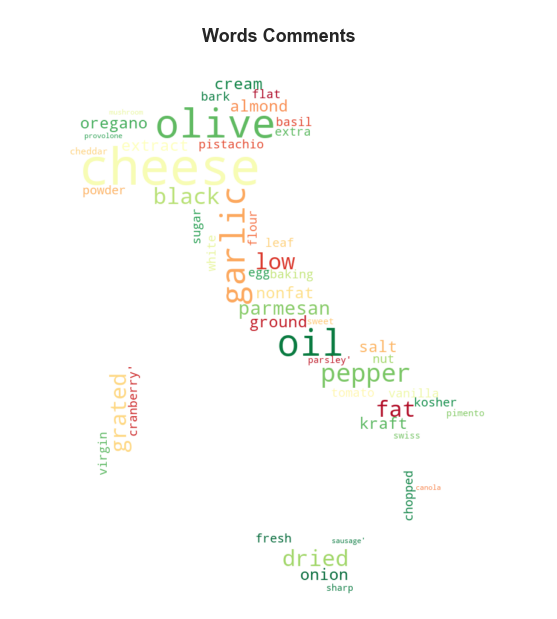

In [111]:
wordcloud = WordCloud(max_font_size=200, max_words=50, background_color="white",
                      mask=ita ,width= 3000, height = 2000,
                      stopwords = stopwords.words('english')).generate(str(italian.final.values))

plot_wordcloud(wordcloud.recolor( colormap= 'RdYlGn' , random_state=17), '\nWords')

d:\anaconda\envs\dataanalytic\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



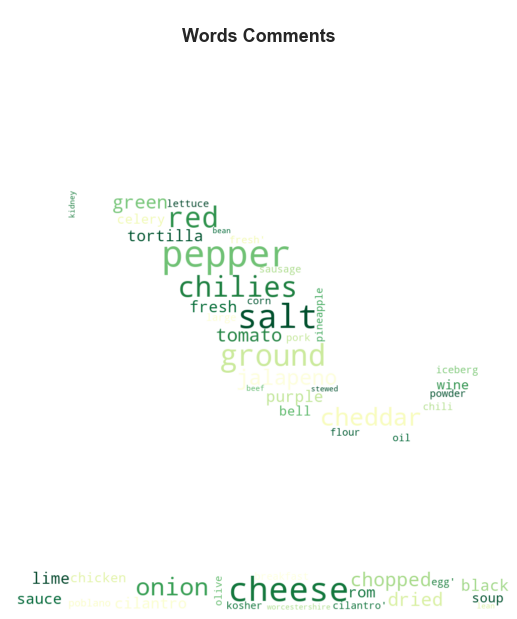

In [112]:
wordcloud = WordCloud(max_font_size=200, max_words=50, background_color="white",
                      mask=mex ,width= 3000, height = 2000,
                      stopwords = stopwords.words('english')).generate(str(mexican.final.values))

plot_wordcloud(wordcloud.recolor( colormap= 'YlGn' , random_state=17), '\nWords')

d:\anaconda\envs\dataanalytic\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



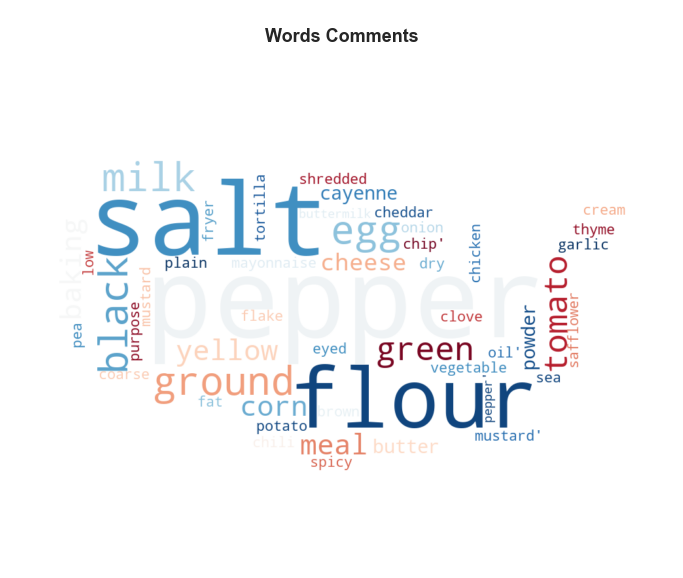

In [113]:
wordcloud = WordCloud(max_font_size=200, max_words=50, background_color="white",
                      mask=sou ,width= 3000, height = 2000,
                      stopwords = stopwords.words('english')).generate(str(southern_us.final.values))

plot_wordcloud(wordcloud.recolor( colormap= 'RdBu' , random_state=17), '\nWords')

d:\anaconda\envs\dataanalytic\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



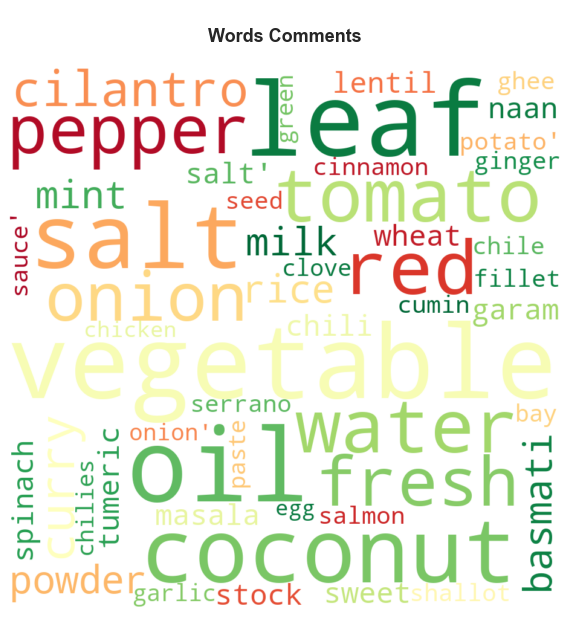

In [114]:
wordcloud = WordCloud(max_font_size=200, max_words=50, background_color="white",
                      mask=ind ,width= 3000, height = 2000,
                      stopwords = stopwords.words('english')).generate(str(indian.final.values))

plot_wordcloud(wordcloud.recolor( colormap= 'RdYlGn' , random_state=17), '\nWords')

d:\anaconda\envs\dataanalytic\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



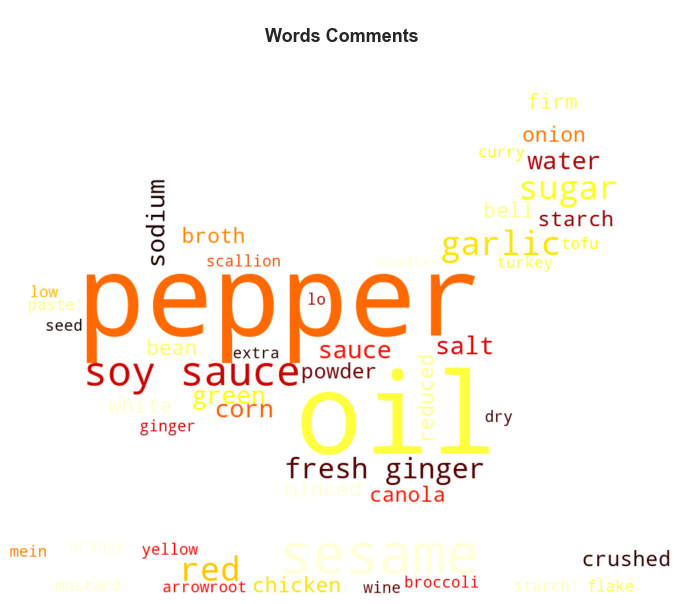

In [115]:
wordcloud = WordCloud(max_font_size=200, max_words=50, background_color="white",
                      mask=chi ,width= 3000, height = 2000,
                      stopwords = stopwords.words('english')).generate(str(chinese.final.values))

plot_wordcloud(wordcloud.recolor( colormap= 'hot' , random_state=17), '\nWords')

# Bag of words